In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


In [2]:
# MNIST Data Loading and Preprocessing
def load_preprocess_mnist():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalizing the data - scale pixel values to range 0 to 1
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # Reshaping data to include channel dimension
    x_train = np.reshape(x_train, (-1, 28, 28, 1))
    x_test = np.reshape(x_test, (-1, 28, 28, 1))

    return x_train, x_test

x_train, x_test = load_preprocess_mnist()


11490434/11490434 [==============================] - 1s 0us/step


In [3]:
from keras import layers
from keras import backend as K
# from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [4]:
def build_convolutional_autoencoder():
    tf.keras.backend.clear_session()
    print("Building a convolutional autoencoder model...")

    # Creating a Sequential model
    model = tf.keras.models.Sequential()

    # Encoder
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=3))
    model.add(layers.Flatten())

    # Bottleneck Layer
    model.add(layers.Dense(10, activation='relu'))

    # Decoder
    model.add(layers.Dense(1152, activation='relu'))
    model.add(layers.Reshape((3, 3, 128)))
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu'))
    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu',padding='same'))
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same'))

    return model



In [5]:
def train_autoencoder(model, x_train, x_test):
    print("Beginning the training process...")

    # Splitting the training data for validation
    x_train, x_val = train_test_split(x_train, test_size=0.33, random_state=42)

    # Model compilation
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Callbacks
    checkpoint_cb = ModelCheckpoint("autoencoder_model.keras", save_best_only=True)
    early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

    # Model training
    history = model.fit(x_train, x_train, epochs=25, batch_size=128,
                        validation_data=(x_val, x_val),
                        callbacks=[checkpoint_cb, early_stopping_cb])

    return history



In [6]:
autoencoder_model = build_convolutional_autoencoder()
autoencoder_model.summary()
len(autoencoder_model.layers)



Building a convolutional autoencoder model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 10)                11530     
                                                                 
 dense_1 (Dense)             (None, 1152)              12672     
                                                                 
 reshape (

10

In [7]:
history = train_autoencoder(autoencoder_model, x_train, x_test)


Beginning the training process...
Epoch 1/25
315/315 [==============================] - 10s 11ms/step - loss: 0.0851 - accuracy: 0.8003 - val_loss: 0.0395 - val_accuracy: 0.8032
Epoch 2/25
315/315 [==============================] - 2s 8ms/step - loss: 0.0298 - accuracy: 0.8030 - val_loss: 0.0261 - val_accuracy: 0.8047
Epoch 3/25
315/315 [==============================] - 3s 10ms/step - loss: 0.0246 - accuracy: 0.8061 - val_loss: 0.0241 - val_accuracy: 0.8068
Epoch 4/25
315/315 [==============================] - 3s 8ms/step - loss: 0.0228 - accuracy: 0.8071 - val_loss: 0.0226 - val_accuracy: 0.8068
Epoch 5/25
315/315 [==============================] - 2s 7ms/step - loss: 0.0217 - accuracy: 0.8077 - val_loss: 0.0221 - val_accuracy: 0.8086
Epoch 6/25
315/315 [==============================] - 2s 8ms/step - loss: 0.0208 - accuracy: 0.8083 - val_loss: 0.0209 - val_accuracy: 0.8084
Epoch 7/25
315/315 [==============================] - 2s 7ms/step - loss: 0.0200 - accuracy: 0.8088 - val_loss:

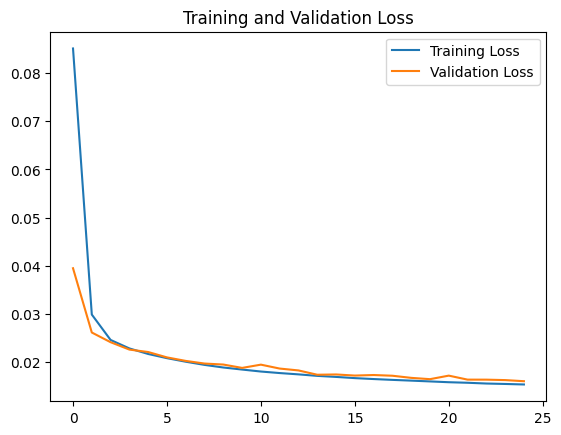

In [8]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [9]:
# Extract the encoder from the autoencoder model
encoder = tf.keras.models.Sequential()
encoder.add(layers.Input(shape=(28, 28, 1)))
# Add layers up to the bottleneck (half of the autoencoder layers)
for i in range(0, len(autoencoder_model.layers)//2):
    encoder.add(autoencoder_model.layers[i])

# Load the MNIST dataset
train_images,test_images = load_preprocess_mnist()

# The train_images and test_images are now preprocessed and ready to be used
encoded_train_images = encoder.predict(train_images)
encoded_test_images = encoder.predict(test_images)

# Print the encoder model summary and the range of values in the encoded images
print(encoder.summary())
print("Max value in encoded test images:", encoded_test_images.max())
print("Max value in encoded train images:", encoded_train_images.max())


313/313 [==============================] - 1s 2ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 10)                11530     
                                                                 
Total params: 104202 (407.04 KB)
Trainable params: 104202 (407.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [10]:
# Function to normalize images
def normalize_images(images, epsilon=1e-7):
    normalized_images = []
    for img in images:
        # Calculate the range of the image (peak-to-peak)
        img_range = np.ptp(img)

        # Avoid division by zero by adding a small value (epsilon)
        norm_img = ((img - np.min(img)) / (img_range + epsilon)) * 255

        # Append the normalized image
        normalized_images.append(norm_img.astype(np.float32))

    return np.asarray(normalized_images)

normalized_dataset = normalize_images(encoded_train_images)
normalized_query = normalize_images(encoded_test_images)



In [ ]:
#Here remains to write the set of normalized image data to a binary file

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
import struct
import numpy as np

def write_to_file(normalized, path):

    normalized = normalized.astype(np.ushort)

    with open(path, "wb") as outputfile:
        number_of_images = normalized.shape[0]
        dimensions = normalized.shape[1]
        # Format for big endian integer
        myfmt = '>i'

        outputfile.write(struct.pack(myfmt, 2051)) # Write magic number

        outputfile.write(struct.pack(myfmt, number_of_images)) # Write number of images

        outputfile.write(struct.pack(myfmt, 1))# Write number of rows

        outputfile.write(struct.pack(myfmt, dimensions)) # Write dimensions

        myfmt = '<' + 'H' * dimensions # Format for little endian unsigned shorts

        for i in range(number_of_images):
            arr = normalized[i]
            outputfile.write(struct.pack(myfmt, *arr))

write_to_file(normalized_dataset, "/content/drive/My Drive/new_input_file.dat")
write_to_file(normalized_query, "/content/drive/My Drive/new_query_file.dat")

